In [1]:
import warnings
warnings.simplefilter("ignore")
#
import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
import os
#
import time
import datetime
import statsmodels.api as sm
import statsmodels.tools.eval_measures as smte
from cmocean import cm as cmo
import xarray as xr
import paramiko
import numpy as np
import pandas as pd
from netCDF4 import num2date
from netCDF4 import Dataset as NetCDFFile
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mc
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import matplotlib.path as mpath
from mpl_toolkits.basemap import Basemap
%matplotlib inline
#
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as feature
#
from cdo import *
cdo=Cdo()

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False,'pcolor.shading':'auto'})

In [3]:
if os.path.exists("format.py") == False:
    os.system("ln -s ../../../anl/sample/format.py")
from format import *
mons=Mon_Name().Mon()

# Before Computing EOFs

In [4]:
tmax=30*12
lonmin=0
lonmax=360
latmin=-90
latmax=-20
latmax2=-60
nlons=128
nlats=25
nlats2=18
numeof=10
infile="z500"

## Making monthly climatology

In [5]:
if os.path.exists(infile) == False:
    os.system("ngted -e AITM3:c'SFC1' ../cat/1dy/z500")
    os.system("ngtavr ../cat/1dy/z500 -m 1mo -o ../cat/z500")
    os.system("ngted -e AITM3:c'SFC1' ../cat/z500")
    os.system("ln -s ../cat/z500")
if os.path.exists(infile+"monmean.nc") == False:
    os.system("ngtcf "+infile)
    cdo.settunits ('-days -settaxis,1981-01-15,12:00,1mon', 
                   input=infile+".nc",output="tmp.nc")
    os.system("mv tmp.nc "+infile+".nc")
    cdo.ymonmean(input=infile+".nc",
                output=infile+"monmean.nc")
    cdo.settunits ('-days -settaxis,1981-01-15,12:00,1mon', 
                   input=infile+"monmean.nc",output="tmp.nc")
    os.system("mv tmp.nc "+infile+"monmean.nc")

## Making anomaly from climatology

In [6]:
if os.path.exists(infile+"_S90-S20_anom.nc") == False:
    cdo.sellonlatbox(str(lonmin)+","+str(lonmax)+","\
                     +str(latmin)+","+str(latmax),\
                     input=infile+".nc",\
                     output=infile+"_S90-S20.nc")
    cdo.sellonlatbox(str(lonmin)+","+str(lonmax)+","\
                     +str(latmin)+","+str(latmax),\
                     input=infile+"monmean.nc",\
                     output=infile+"monmean_S90-S20.nc")
    cdo.sub(input=infile+"_S90-S20.nc "+infile+"monmean_S90-S20.nc", output=infile+"_S90-S20_anom.nc")

## Check trend

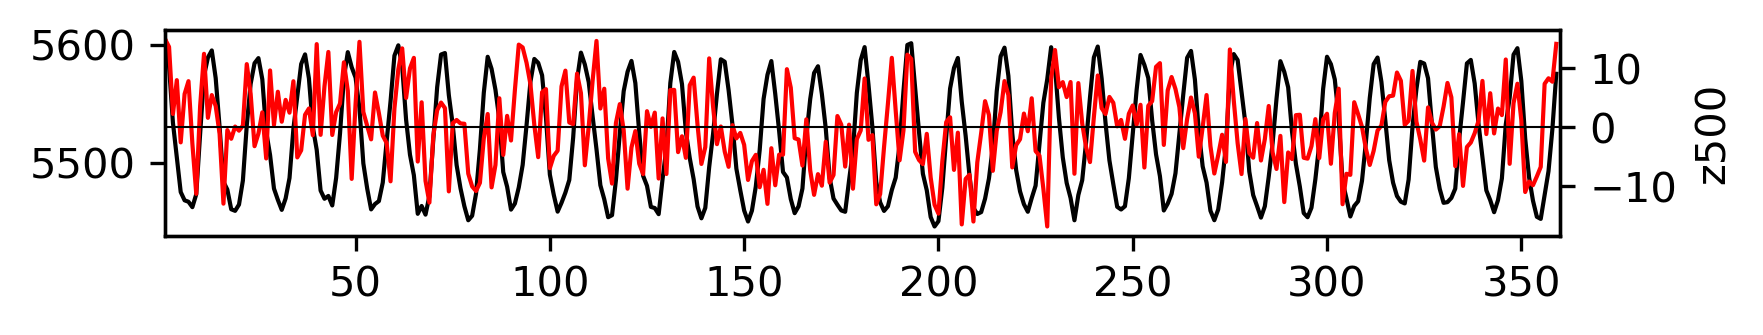

In [7]:
if os.path.exists(infile+"_S90-S20_anom_fldmean.nc") == False:
    cdo.fldmean(input=infile+"_S90-S20.nc",output=infile+"_S90-S20_fldmean.nc")
    cdo.fldmean(input=infile+"_S90-S20_anom.nc",output=infile+"_S90-S20_anom_fldmean.nc")
#
fldmean     = NetCDFFile(infile+"_S90-S20_fldmean.nc"     ).variables["zg"][:,0,0]
fldmeananom = NetCDFFile(infile+"_S90-S20_anom_fldmean.nc").variables["zg"][:,0,0]
time        = np.arange(0,tmax,1)
#
plt.rcParams["figure.dpi"] = 300
fig = plt.figure(figsize=(6,2))
ax1 = fig.add_subplot(2,1,1)
ax2 = ax1.twinx()
ax1.plot(    time,fldmean,
         color="black",linewidth=1, label="raw")
ax2.plot(    time,fldmeananom,
         color="red",linewidth=1, label="anom")
ax2.axhline(y=0,color="k",ls="-",linewidth=0.5)
plt.xlim([1,tmax])
plt.xlabel("Number of mons")
plt.ylabel("z500")
#plt.legend(loc="best")          
plt.show()

## Check fields

In [8]:
def LatLon(nlons):
    dlats            = NetCDFFile(infile+"_S90-S20.nc").variables["lat"]
    dlons            = NetCDFFile(infile+"_S90-S20.nc").variables["lon"]
    dlons2=np.zeros(nlons+1)
    dlons2[0:nlons]=dlons[:]
    dlons2[nlons]=-1*dlons[0]
    flon,flat=np.meshgrid(dlons2,dlats)
    return flon, flat

def LonLat2(nlons,nlats):
    delta = 2.*np.pi/(nlons-1)
    lons = (delta*np.indices((nlats,nlons))[1,:,:])
    lats = -1*(0.5*np.pi - delta*np.indices((nlats,nlons))[0,:,:])
    return lons,lats

def xy(lons,lats,m):
    x, y = m(lons*180./np.pi, lats*180./np.pi) 
    return x,y



In [9]:
if os.path.exists(infile+"timeselmean.nc") == False:
    cdo.timselmean(tmax,
                  input=infile+"_S90-S20.nc",
                  output=infile+"_S90-S20_timeselmean.nc")
mean=NetCDFFile(infile+"_S90-S20_timeselmean.nc").variables["zg"][0,:,:]
mean2=np.zeros((nlats,nlons+1)) 
mean2[:,0:nlons]=mean[:,:]
mean2[:,nlons]=mean[:,0]
if os.path.exists(infile+"timeselmean.nc") == False:
    cdo.timselstd(tmax,
                  input=infile+"_S90-S20_anom.nc",
                  output=infile+"_S90-S20_timeselstd.nc")
std=NetCDFFile(infile+"_S90-S20_timeselstd.nc").variables["zg"][0,:,:]
std2=np.zeros((nlats,nlons+1)) 
std2[:,0:nlons]=std[:,:]
std2[:,nlons]=std[:,0]
monmean=NetCDFFile(infile+"monmean_S90-S20.nc").variables["zg"]


monanom=np.zeros((12,25,128))
anommean=np.zeros((25,128))
for mon in range(12):
    monanom[mon,:,:]=monmean[mon,:,:]-mean[:,:]
monanom2=np.zeros((12,nlats,nlons+1)) 
monanom2[:,:,0:nlons]=monanom[:,:,:]
monanom2[:,:,nlons]=monanom[:,:,0]

### Mean & standard deviation

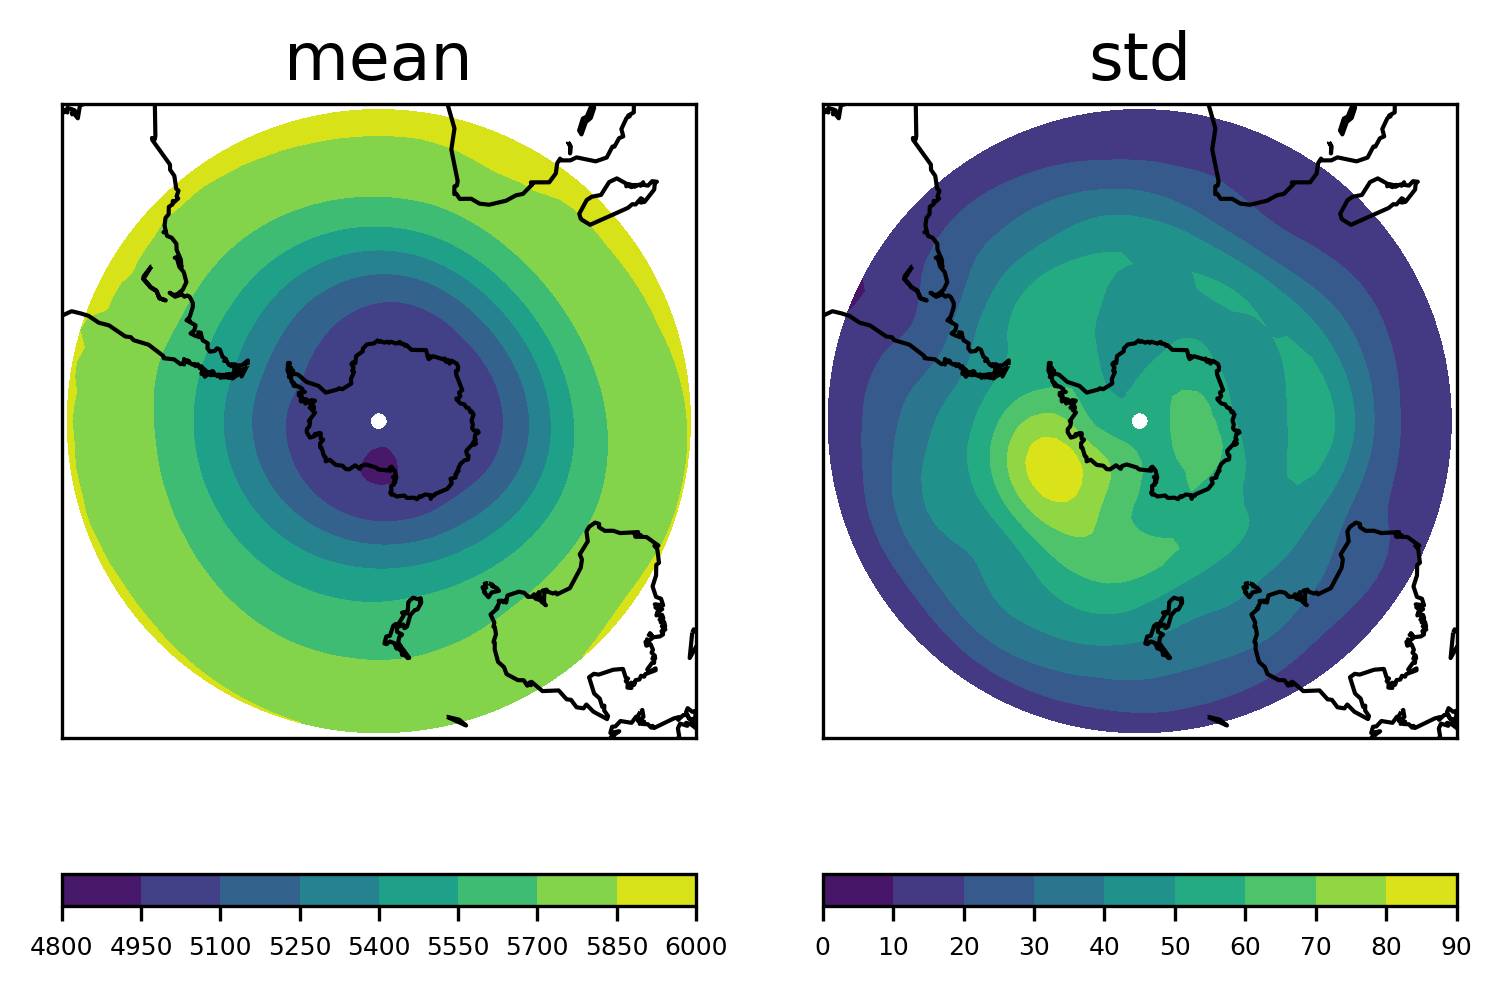

In [10]:
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(6,4)) 
flon,flat=LatLon(nlons)

ax = plt.subplot(1,2,1)
ax.set_title("mean", fontsize=16) 
m = Basemap(projection='spstere', lon_0=180,boundinglat=latmax) 
x,y=m(flon,flat) 
m.drawcoastlines()
cs = m.contourf(x,y,mean2)
cbar=plt.colorbar(cs, orientation='horizontal') 
cbar.ax.tick_params(labelsize=6) 

ax = plt.subplot(1,2,2)
ax.set_title("std", fontsize=16) 
m = Basemap(projection='spstere', lon_0=180,boundinglat=latmax) 
m.drawcoastlines()
cs = m.contourf(x,y,std2)
cbar=plt.colorbar(cs, orientation='horizontal') 
cbar.ax.tick_params(labelsize=6) 

fig.show()

### Monthly anomaly

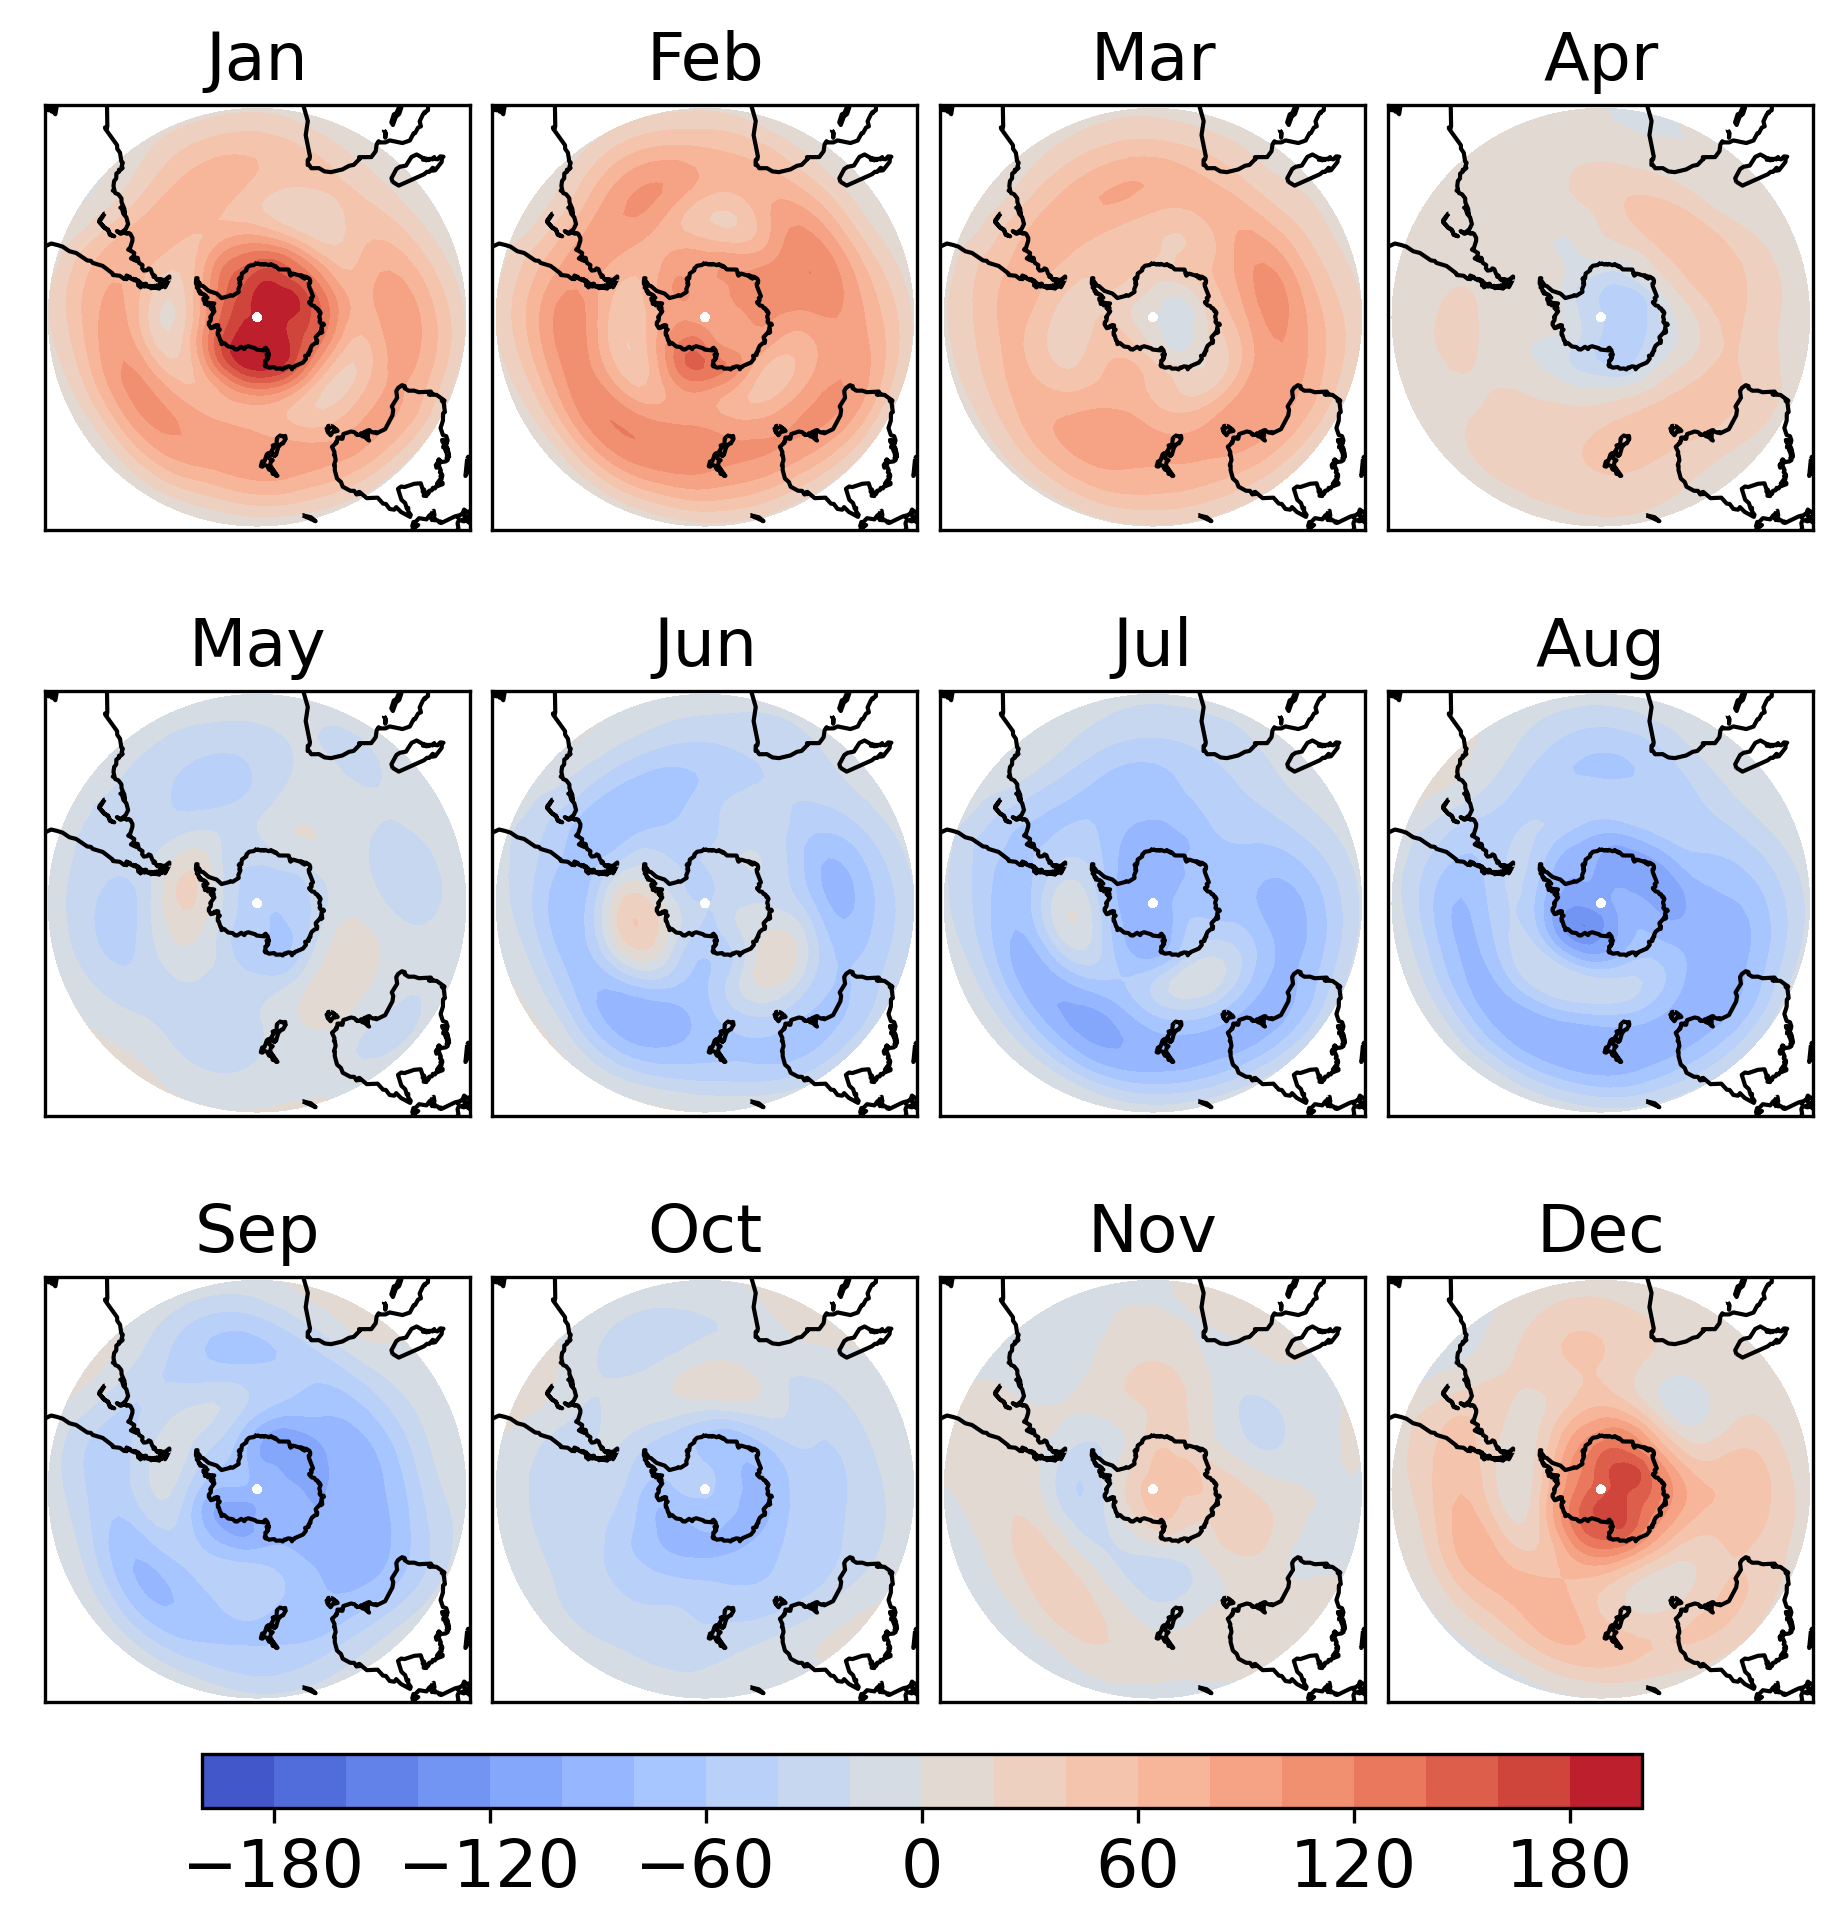

In [11]:
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(6,6)) 
lons,lats = LonLat2(nlons,nlats)
levels=np.arange(-200,220,20)
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    ax.set_title(mons["name"][i], fontsize=16) 
    m = Basemap(projection='spstere', lon_0=180,boundinglat=latmax) 
    m.drawcoastlines()
    cs = m.contourf(x,y,monanom2[i,:,:],cmap="coolwarm",levels=levels) 

cax = fig.add_axes([0.1, -0.01, 0.8, 0.03])
art = plt.colorbar(cs, cax, orientation='horizontal')
art.ax.tick_params(labelsize=16) 
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2) 
plt.show()

## Compute EOFs

In [12]:
if os.path.exists(infile+"eofmonorg_pc_00000.nc") == False:
    # compute modes
    cdo.eof(str(numeof), \
            input="-setmisstoc,0 "+infile+"_S90-S20_anom.nc", \
            output=infile+"evalmonorg.nc "+infile+"eofmonorg.nc") 
    # compute principal coefficients
    cdo.eofcoeff(input=infile+"eofmonorg.nc "+infile+"_S90-S20_anom.nc"\
                 , output=infile+"eofmonorg_pc_") 

In [13]:
if os.path.exists(infile+"conmonorg.nc") == False:
    #--read output data
    ff = cdo.seltimestep("1/"+str(numeof), input=infile+"eofmonorg.nc", \
                         options='-f nc', returnCdf=True) 
    # read eigen vectors
    eof = ff.variables["zg"][:,:,:] 
    # for variance calculation
    cdo.remapcon("r"+str(nlons)+"x"+str(nlats),\
                 input=infile+"_S90-S20_anom.nc",\
                 output=infile+"conmonorg.nc") 
#    
if os.path.exists(infile+"evalmonorg_noweight.nc") == False:
    if os.path.exists(infile+"variancemonorg.txt") == True:
        os.system("rm "+infile+"variancemonorg.txt")
    #
    # Making a script
    os.system("echo export CDO_WEIGHT_MODE=off >  "
              +infile+"variancemonorg.sh")
    os.system("echo numeof=10                  >> "
              +infile+"variancemonorg.sh")
    os.system("echo eval_file="+infile+"evalmonorg_noweight.nc >> "
              +infile+"variancemonorg.sh")
    os.system("echo eof_file="+infile+"eofmonorg_noweight.nc   >> "
              +infile+"variancemonorg.sh")              
    os.system("echo inp_file="+infile+"conmonorg.nc            >> "
              +infile+"variancemonorg.sh")  
    os.system("echo 'cdo eof,${numeof} ${inp_file} ${eval_file} ${eof_file}' >> "
              +infile+"variancemonorg.sh")  
    os.system("echo 'cdo fldsum -timvar ${inp_file} tot1.nc'         >> "
              +infile+"variancemonorg.sh")
    os.system("echo 'for ((i=1; i<=${numeof}; ++i)) ; do'            >> "
              +infile+"variancemonorg.sh")
    os.system("echo 'cdo -seltimestep,${i} ${eval_file} tot2.nc'     >> "
              +infile+"variancemonorg.sh")
    
    os.system("echo 'mode=`cdo output -mulc,100 -div tot2.nc tot1.nc | sed  \"s- --g\"`' >> "
              +infile+"variancemonorg.sh")
    os.system("echo 'echo EOF MODE ${i}: ${mode} >>"+infile+"variancemonorg.txt' >> "
              +infile+"variancemonorg.sh")  
    os.system("echo done    >> "
              +infile+"variancemonorg.sh")  
    # Run script
    os.system("chmod 755 "+infile+"variancemonorg.sh")
    os.system("./"+infile+"variancemonorg.sh")
    os.system("rm tot1.nc tot2.nc")

In [14]:
cor=np.zeros(numeof+1)
jj=0
for line in open(infile+'variancemonorg.txt', 'r'):
    jj=jj+1
    va, vb, vc, vd= line[:-1].split(' ') 
#    print(va,vb,vc,vd) 
    cor[jj]=round(float(vd),2)

In [15]:
numeof2=3
labels=["SAM","PSA1","PSA2"]

In [39]:
sign=[1,1,-1,-1,1,1,-1,-1,1,1] # sign for each mode #
ff = cdo.seltimestep("1/"+str(numeof), input=infile+"eofmonorg.nc",\
                     options='-f nc', returnCdf=True) 
# read eigen vectors
eof = ff.variables["zg"][:,:,:] # read eigen vectors
eof2=np.zeros((numeof,nlats,nlons+1)) 
eof2[:,:,0:nlons]=eof[:,:,:]
eof2[:,:,nlons]=eof[:,:,0]

In [40]:
pc2=np.zeros((tmax,numeof2))
detrend2=np.zeros((tmax,numeof2))
trend2=np.zeros((tmax,numeof2))
for ii in range(numeof2):
    if os.path.exists(infile+"eofmonorg_pc_%5.5i_trend.nc" % (ii)) == False:
        cdo.detrend(input=infile+"eofmonorg_pc_%5.5i.nc" % (ii),output=infile+"eofmonorg_pc_%5.5i_detrend.nc" % (ii))
    pc = NetCDFFile(infile+"eofmonorg_pc_%5.5i.nc" % (ii)).variables["zg"][:,0,0]
    pc2[:,ii] = (pc-pc.mean())/pc.std()*sign[ii]
    detrend = NetCDFFile(infile+"eofmonorg_pc_%5.5i_detrend.nc" % (ii)).variables["zg"][:,0,0]
    detrend2[:,ii] = detrend/detrend.std()*sign[ii]
    trend2[:,ii]   = pc2[:,ii]  - detrend2[:,ii]
    eof2[ii,:,:] = eof2[ii,:,:]*pc.std()

# EOFs

In [31]:
def Color_Set(levels,cmapname):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mc
    cmap = plt.get_cmap(cmapname, len(levels)+1)
    colors = cmap(range(cmap.N))
    cmap, norm = mc.from_levels_and_colors(levels,colors,extend="both")
    return cmap, norm     

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm, rgb2hex

def make_colorpalet(colorname="viridis",levels=[10,30,60,70,90]):
    # https://hackmd.io/@h2tg95D2RP2ed-D8u-49Mg/S1moBqaRr
    white="#ffffff"
    lightcyan="#E0FFFF"
    paleturquoise="#AFEEEE"
#    color_code=[paleturquoise,lightcyan,white]
    color_code=[paleturquoise,white]
    num = len(levels)-len(color_code)+1
    color_code.extend(get_color_code(colorname,num)[:])

    # カラーマップ作成(→ 1)
    cmap, norm = mc.from_levels_and_colors(levels,color_code,extend="both")
    
    return cmap, norm 

def get_color_code(cname,num):
    cmap = cm.get_cmap(cname,num)

    code_list =[]
    for i in range(cmap.N):
        rgb = cmap(i)[:3]
#        print(rgb2hex(rgb))
        code_list.append(rgb2hex(rgb))

    return code_list

In [33]:
z500_levels = [-100, -70,-50,-40,-30, -20, -10, -5,-1,1,5,  10,20,30,40,50,70,100]
z500_cmapname = "twilight_shifted"
z500_cmap, z500_norm = Color_Set(z500_levels, z500_cmapname)
color_code=(get_color_code(z500_cmapname,len(z500_levels)+1)[:])
mid=(len(color_code)-1)/2
color_code[int(mid)]="#ffffff"
z500_cmap, z500_norm = mc.from_levels_and_colors(z500_levels,color_code,extend="both")
z500_label = "Geopotential height (500 hPa) [m]"           

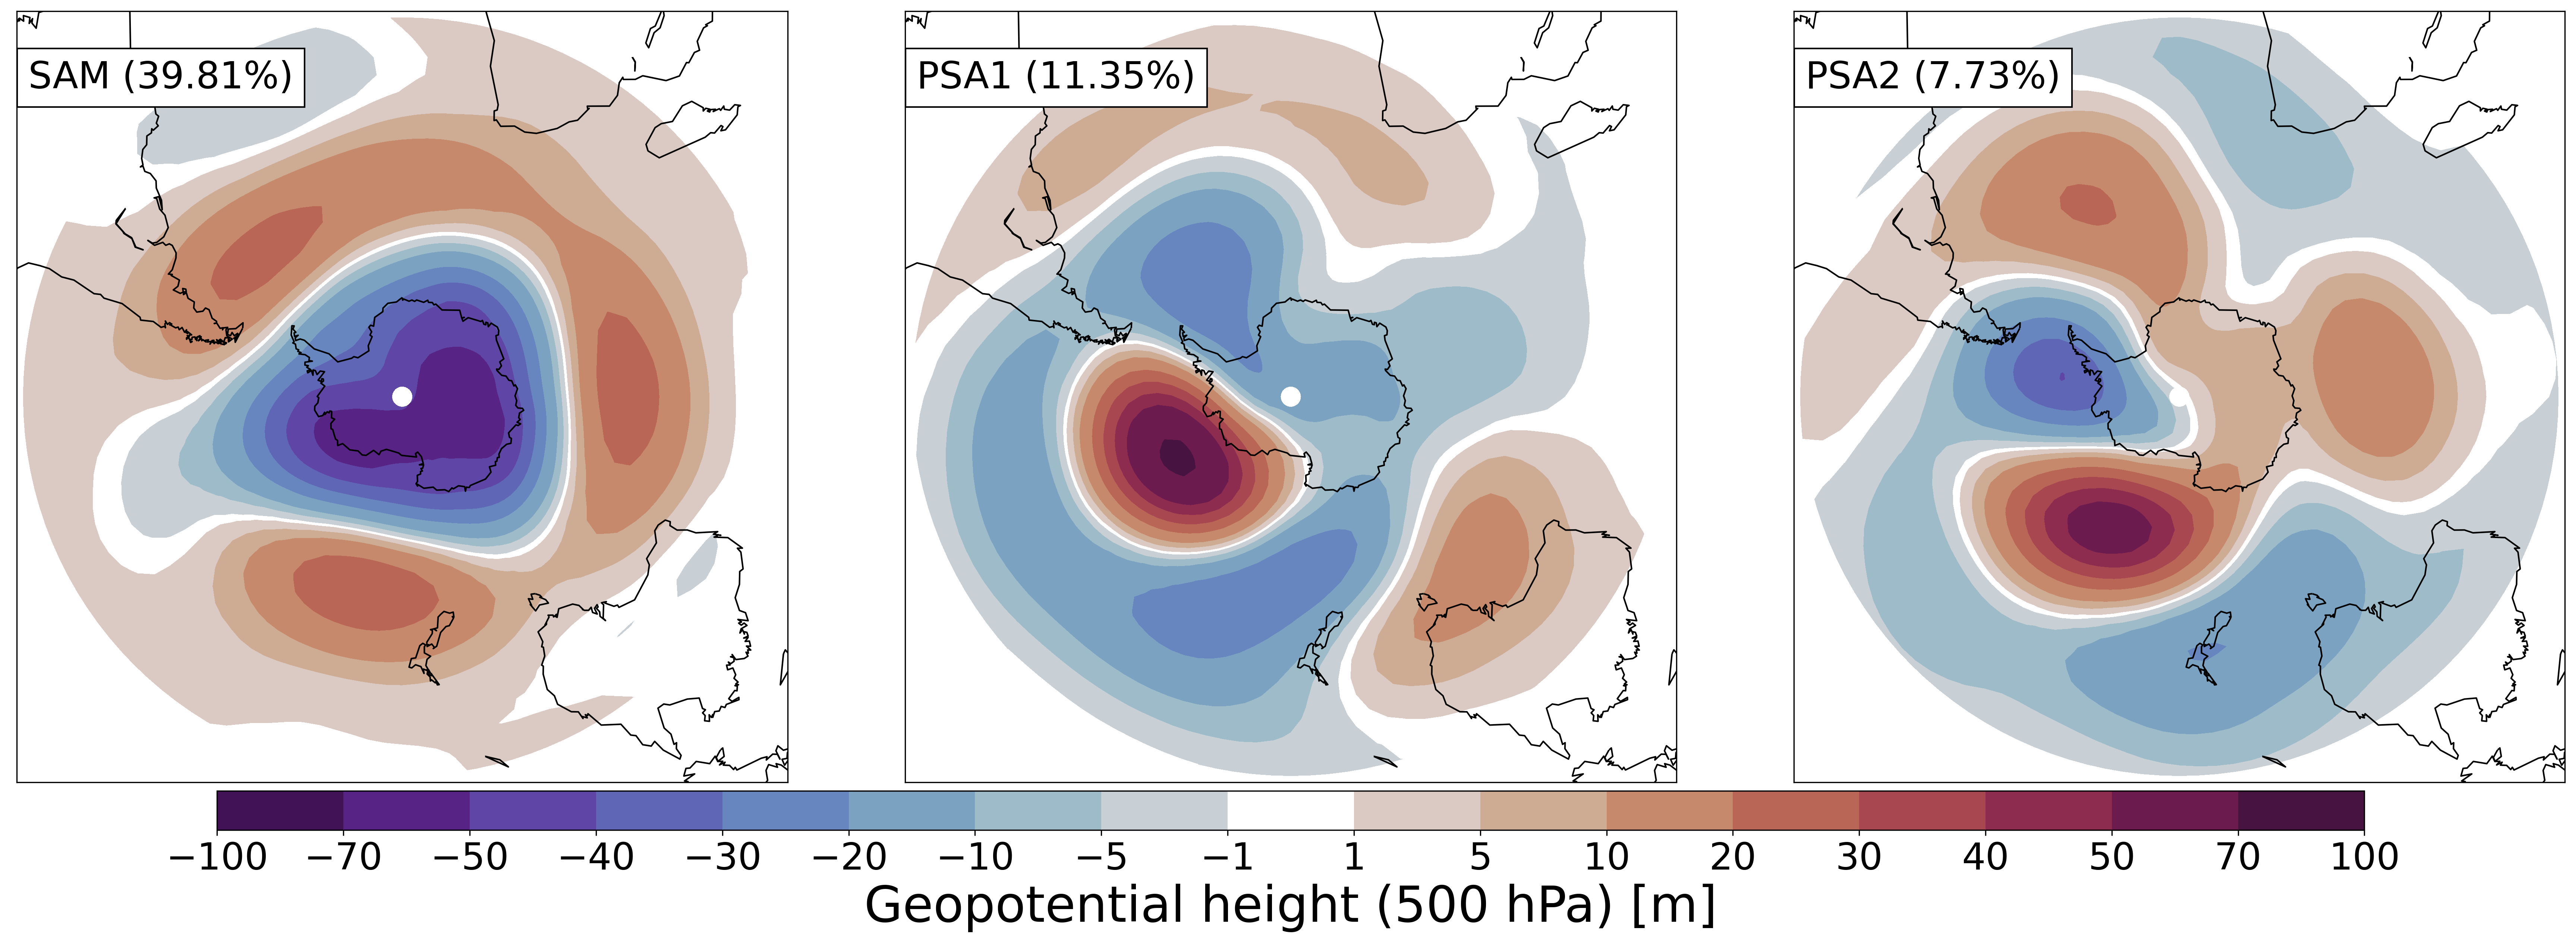

In [41]:
fig = plt.figure(figsize=(24,7)) 
lons,lats = LonLat2(nlons,nlats)
jj=0
for ii in range(numeof2):
#----draw eigen vector
    jj=jj+1
    ax = plt.subplot(1,numeof2,jj)
    m = Basemap(projection='spstere', lon_0=180, 
                boundinglat=latmax) 
    m.drawcoastlines()

    cs = m.contourf(x,y,eof2[ii,:,:],
                    norm=z500_norm,cmap=z500_cmap,levels=z500_levels)
    ax.text(0.015,0.9, labels[ii] +
            " ("+str(cor[ii+1])+"%)" ,
            transform=ax.transAxes, fontsize=24, 
            bbox=dict(boxstyle='square',fc='w', 
                      alpha=1.0), zorder=100)
    
cax = fig.add_axes([0.1, -0.05, 0.8, 0.05])
art = plt.colorbar(cs, cax,orientation='horizontal',ticks=z500_levels)

art.set_label(z500_label, fontsize=32) 
art.ax.tick_params(labelsize=24) 
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.3) 
plt.show()

In [42]:
fig = plt.figure(figsize=(24,30)) 
jj=0
for ii in range(numeof2):
    #----plot PC
    jj=jj+1
    ax = plt.subplot(numeof2,1,jj) #
    f3 = cdo.selname("zg",input=infile+"eofmonorg_pc_%5.5i.nc" % (ii),
                     options='-f nc', returnCdf=True)

    xx = np.arange(0,len(pc2[:,ii]),1) #
    lns3 = ax.plot(xx, pc2[:,ii], "-", ms=10, color="black", linewidth=2) 
    ax.bar(xx,pc2[:,ii],width=1)

    ax.plot(xx,trend2[:,ii],color="red",linewidth=3)
    #
    ax.tick_params(labelsize=24)
    ax.set_xticks(np.arange(0,360,12))
    ax.set_xticklabels(np.arange(1981,2011),rotation=70)
    ax.set_ylabel(labels[ii]+"-index",fontsize=32) 
    ax.set_ylim((-3.0,3.0))
    ax.axvline(x=120,ls='--',linewidth=1, color='k')
    ax.axvline(x=240,ls='--',linewidth=1, color='k')
    ax.axhline(y=1,ls='--',linewidth=1, color='k')
    ax.axhline(y=0,ls='--',linewidth=1, color='k')
    ax.axhline(y=-1,ls='--',linewidth=1, color='k')
    
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.5) 
plt.show()

In [45]:
# 日付情報
time = NetCDFFile(infile+".nc").variables["time"][:]
date_offset = datetime.datetime(1981,1,1)
date_offset.day

y = np.zeros(tmax)
m = np.zeros(tmax)
d = np.zeros(tmax)

for tt in range(tmax):
    time_data = date_offset+datetime.timedelta(days=time[tt])
    y[tt] = time_data.year
    m[tt] = time_data.month
    d[tt] = time_data.day

np.savez("sammon.npz",sam=pc2[:,0], y=y, m=m, d=d)
np.savez("psa1mon.npz",sam=pc2[:,1], y=y, m=m, d=d)
np.savez("psa2mon.npz",sam=pc2[:,2], y=y, m=m, d=d)